In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

# Load and check pooled endothelial object

In [4]:
#Load pooled endothlial object - prenatal skin and skin organoid

endo_object = 'pooled_endothelium.processed.cellxgene.h5ad'
endo_path = root_path + endo_object
edata = sc.read(endo_path)

Only considering the two last: ['.cellxgene', '.h5ad'].
Only considering the two last: ['.cellxgene', '.h5ad'].


In [5]:
edata

AnnData object with n_obs × n_vars = 2048 × 15445
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'joint_annot', 'annot'
    var: 'gene_ids'
    obsm: 'X_umap_hm'

In [6]:
# names of LE amended in final object and figures
# 'Early LE' = 'PROX1-hi LE'
# 'LE' = 'LYVE1-hi LE'
print(list(edata.obs['joint_annot'].unique()))

['LE', 'Postcapillary venules', 'Venules', 'Early LE', 'Capillary arterioles', 'Early endothelial cells', 'Capillaries', 'Arterioles']


In [7]:
print(list(edata.obs['annot'].unique()))

['fsk_LE', 'fsk_Postcapillary venules', 'fsk_Early LE', 'fsk_Capillary arterioles', 'fsk_Early endothelial cells', 'fsk_Capillaries', 'fsk_Arterioles', 'fsk_Venules', 'org_Endothelium']


In [8]:
data = pd.crosstab(index=edata.obs['joint_annot'],
                   columns=edata.obs['dataset'],
                   margins=True)
print(data)

dataset                  fetal_skin  organoid   All
joint_annot                                        
Early endothelial cells         121         0   121
Early LE                         54         0    54
LE                              479         0   479
Arterioles                      168         3   171
Capillary arterioles            125       100   225
Capillaries                     400         1   401
Postcapillary venules           464         0   464
Venules                         133         0   133
All                            1944       104  2048


In [9]:
#create new annotation column to use and rename organoid capillary arterioles
edata.obs['joint_annot_copy'] = edata.obs['joint_annot']
edata.obs['joint_annot_copy'] = np.where((edata.obs['joint_annot_copy'] == 'Capillary arterioles') & (edata.obs['dataset'] == 'organoid'), 
                                          'Capillary arterioles (organoid)', edata.obs['joint_annot_copy'])

In [10]:
data2 = pd.crosstab(index=edata.obs['joint_annot_copy'],
                   columns=edata.obs['dataset'],
                   margins=True)
print(data2)

dataset                          fetal_skin  organoid   All
joint_annot_copy                                           
Arterioles                              168         3   171
Capillaries                             400         1   401
Capillary arterioles                    125         0   125
Capillary arterioles (organoid)           0       100   100
Early LE                                 54         0    54
Early endothelial cells                 121         0   121
LE                                      479         0   479
Postcapillary venules                   464         0   464
Venules                                 133         0   133
All                                    1944       104  2048


# Plot umap

In [11]:
edata_fs = edata[edata.obs['dataset'] == "fetal_skin"]
edata_or = edata[edata.obs['dataset'] == "organoid"]

(-13.83076982498169, 9.818372058868409)

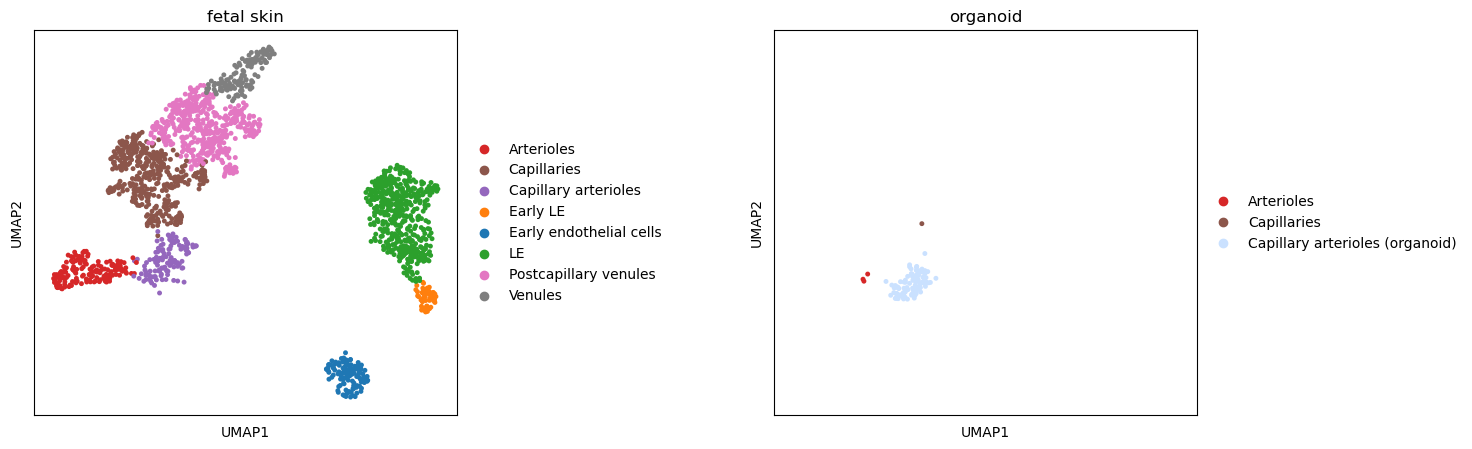

In [12]:
sk.set_figsize((15, 5))
fig = plt.figure()
spec = fig.add_gridspec(ncols=2, nrows=1)
spec.update(wspace=0.75, hspace=0.05) # set the spacing between axes.

f1 = fig.add_subplot(spec[0,0])
f2 = fig.add_subplot(spec[0,1])


#sc.set_figure_params(dpi=80, color_map='viridis')

# legend_loc : str (default: 'right margin')

#fig1 = sc.pl.umap(pbmc, color=['bulk_labels'], s=50, show=False, ax=f1)
fig1 = sc.pl.embedding(edata_fs, basis='X_umap_hm', color=['joint_annot_copy'], s=50, show=False, ax=f1, title='fetal skin',
                      palette={'Early endothelial cells': 'tab:blue',
                                'Early LE': 'tab:orange', 
                                'LE': 'tab:green',
                                'Arterioles': 'tab:red',
                                'Capillary arterioles': 'tab:purple' ,
                                'Capillaries': 'tab:brown' ,
                                'Postcapillary venules': 'tab:pink',
                                'Venules': 'tab:gray'})
f1.set(xlabel="UMAP1", ylabel="UMAP2")
# groups
#fig1 = sc.pl.embedding(fo_ad, basis='X_umap_hm', color=['joint_annot'], s=50, show=False, ax=f1, groups=['Tip cell (arterial)'])

#fig2 = sc.pl.umap(pbmc, color=['bulk_labels'], s=100, show=False, ax=f2)
fig2 = sc.pl.embedding(edata_or, basis='X_umap_hm', color=['joint_annot_copy'], s=50, show=False, ax=f2, title='organoid',
                      palette={'Capillary arterioles (organoid)': '#CAE1FF',
                               'Arterioles': 'tab:red',
                               'Capillaries': 'tab:brown'})
f2.set(xlabel="UMAP1", ylabel="UMAP2")

f2.set_xlim((f1.get_xlim()))
f2.set_ylim((f1.get_ylim()))

#fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig5_umap1.pdf", bbox_inches="tight")

In [13]:
#Define order and colours for endothelial cells
edata.obs['joint_annot_copy'] = pd.Categorical(edata.obs.joint_annot_copy)

edata.obs['joint_annot_copy'].cat.reorder_categories(['Early endothelial cells',
                                                      'Early LE', 
                                                      'LE',
                                                      'Arterioles',
                                                      'Capillary arterioles',
                                                      'Capillaries',
                                                      'Postcapillary venules',
                                                      'Venules',
                                                      'Capillary arterioles (organoid)',                                                            
                                                        ], inplace=True)

print(edata.obs['joint_annot_copy'].cat.categories)

# now set values:
edata.uns['joint_annot_copy_colors'] = ['tab:blue',
                                         'tab:orange',
                                         'tab:green',
                                         'tab:red',
                                         'tab:purple',
                                         'tab:brown',
                                         'tab:pink',
                                         'tab:gray',
                                         '#CAE1FF']

Index(['Early endothelial cells', 'Early LE', 'LE', 'Arterioles',
       'Capillary arterioles', 'Capillaries', 'Postcapillary venules',
       'Venules', 'Capillary arterioles (organoid)'],
      dtype='object')


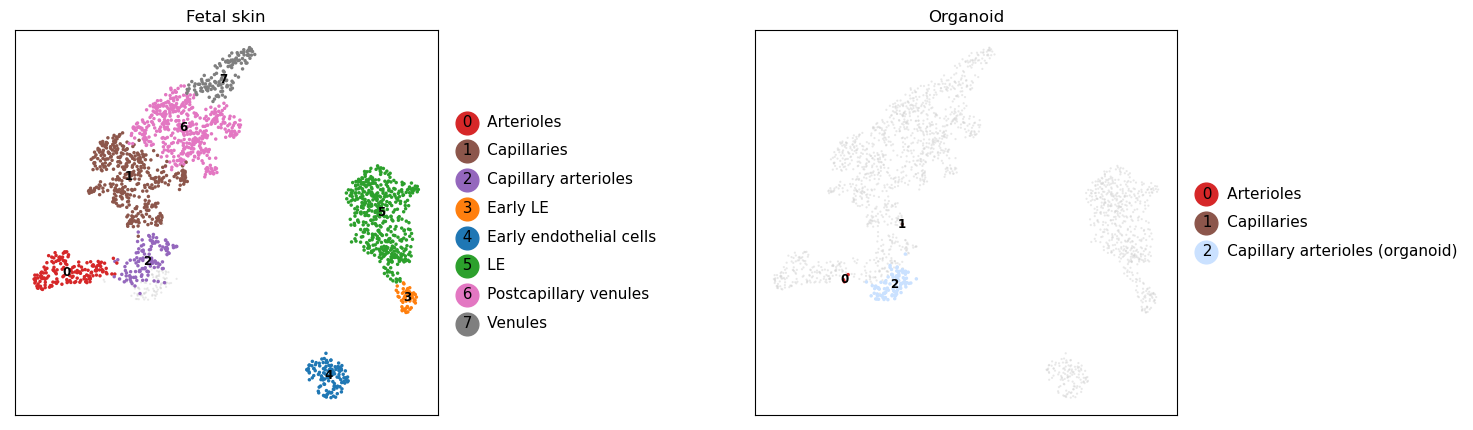

In [14]:
sk.set_figsize((15, 5))
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={"wspace": 0.75})

sc.pl.embedding(edata, basis="umap_hm", size=10, alpha=0.5, show=False, ax=axs[0])
sk.plot_embedding(edata_fs,
    basis="umap_hm",
    groupby="joint_annot_copy",
    size=25,
    legend_fontsize=10,
    #legend_loc="right",
    title="Fetal skin",
    ax=axs[0],
    show=False,
)
sc.pl.embedding(edata, basis="umap_hm", size=10, alpha=0.5, show=False, ax=axs[1])
sk.plot_embedding(edata_or,
    basis="umap_hm",
    groupby="joint_annot_copy",
    size=25,
    legend_fontsize=10,
    title="Organoid",
    ax=axs[1],
    show=False,
)
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
#fig.savefig("/home/jovyan/projects/skin/fetal_skin/figures/other plots/Fig5_umap2.pdf", bbox_inches="tight")
gc.collect();

# Gene scores

In [15]:
edata

AnnData object with n_obs × n_vars = 2048 × 15445
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'joint_annot', 'annot', 'joint_annot_copy'
    var: 'gene_ids'
    uns: 'joint_annot_copy_colors'
    obsm: 'X_umap_hm'

## Gene module scores - Angiogenesis potential: Tip and stalk scores

In [16]:
# Define gene sets and compute tip and stalk scores
gene_tip = ['ADM', 'ANKRD37', 'C1QTNF6', 'DLL4', 'COL4A2',
            'EDNRB', 'FSCN1', 'GPIHBP1', 'HSPG2', 'IGFBP3',
            'INHBB', 'KCNE3', 'LAMA4', 'LXN', 'MCAM',
            'MEST', 'NID2', 'NOTCH4', 'PTN', 'RBP1',
            'RGCC', 'UNC5B']
gene_stalk = ['ACKR1', 'AQP1', 'C1QTNF9', 'CD36', 'CSRP2',
            'EHD4', 'FBLN5', 'HSPB1', 'LIGP1', 'IL6ST',
            'JAM2', 'LGALS3', 'LRG1', 'MEOX2', 'PLSCR2',
            'SDPR', 'SELP', 'SPINT2', 'TGFBI', 'TGM2',
            'TMEM176A', 'TMEM176B', 'TMEM252', 'TSPAN7', 'VEGFR1',
           'VWF']


sc.tl.score_genes(edata, gene_list=gene_tip, score_name="tip_score") # used with default parameters ctrl_size=50, n_bins=25
sc.tl.score_genes(edata, gene_list=gene_stalk, score_name="stalk_score") # used with default parameters ctrl_size=50, n_bins=25

computing score 'tip_score'
    finished: added
    'tip_score', score of gene set (adata.obs).
    396 total control genes are used. (0:00:00)
computing score 'stalk_score'
    finished: added
    'stalk_score', score of gene set (adata.obs).
    599 total control genes are used. (0:00:00)


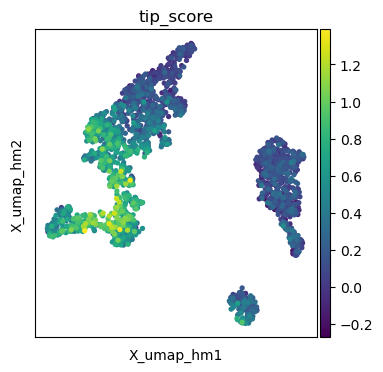

In [17]:
sc.pl.embedding(edata, basis='X_umap_hm', color=['tip_score'])
#sc.pl.embedding(edata, basis='X_umap_hm', color=['tip_score'], save='tip_score.pdf')

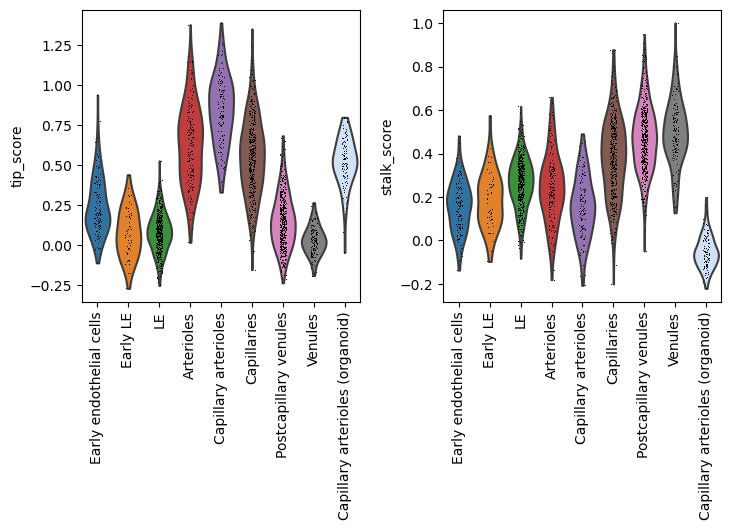

In [25]:
#Tip and stalk scores per celltype

sc.pl.violin(edata, ['tip_score', 'stalk_score'], groupby='joint_annot_copy', rotation=90, size=0.7)
#sc.pl.violin(edata, ['tip_score', 'stalk_score'], groupby='joint_annot_copy', rotation=90, size=0.7, save='tip_stalk_scores.pdf')

## Gene module scores - by celltype

In [26]:
# Define gene sets and compute tip and stalk scores
gene_arterioles = ['EFNB2', 'SOX17', 'BMX', 'SEMA3G', 'HEY1', 'LTBP4', 'FBLN5', 'GJA5', 'GJA4', 'FBLIM1', 'FBLN2', 'MGP', 'BGN', 'LTBP1', 'FN1',
                   'SERPINE2', 'CPAMD8', 'CXCL12', 'VEGFA', 'DKK2', 'DLL4', 'SOX5', 'HES4', 'PRDM16', 'IGFBP3', 'SRGN', 'SAT1', 'SLC9A3R2',
                   'RHOB', 'BST2', 'JAG1']
gene_capillaries = ['CA4', 'PRX', 'RGCC', 'SPARC', 'SGK1', 'CYB5A', 'ACVRL1', 'TMEM100', 'ADGRF5', 'ADGRL2', 'F2RL3', 'IFNGR1', 'VIPR1', 
                    'ARHGAP6', 'IFI27', 'PREX1', 'PRKCE', 'SH2D3C', 'SORBS1', 'EMP2', 'ITGA1', 'SLC9A3R2', 'AFF3', 'MEIS1', 'BTNL9', 'KIAA1217',
                    'FCN3', 'IL7R', 'CD36', 'NRXN3', 'SLC6A4', 'GPIHBP1', 'ARHGAP18','IL18R1']
gene_venules = ['NR2F2', 'VCAM1', 'ACKR1', 'SELP', 'SELE', 'ADAMTS9', 'IGFBP7', 'HDAC9', 'RORA', 'ACTN1', 'LDLRAD3', 'LDLRAD4', 'LRRC1', 'MCTP1',
                'VWF', 'COL15A1', 'ZNF385D', 'EBF1', 'TSHZ2', 'FLRT2', 'OLFM1', 'CPXM2', 'PLVAP', 'PDE7B', 'VWA1', 'SPRY1', 'CLU', 'MGP', 'IER3',
                'PERP', 'EDN1', 'FBLN2', 'LYST']
gene_LE = ['PROX1', 'FLT4', 'PDPN', 'CCL21', 'SEMA3A', 'SEMA3D', 'TBX1', 'HOXD3', 'NR2F1', 'NR2F2', 'KDR', 'TEK', 'TFF3', 'TM4SF18', 
           'SNCG', 'SCN3B', 'RELN', 'KLHL4']


sc.tl.score_genes(edata, gene_list=gene_arterioles, score_name="arterioles_score") # used with default parameters ctrl_size=50, n_bins=25
sc.tl.score_genes(edata, gene_list=gene_capillaries, score_name="capillaries_score") # used with default parameters ctrl_size=50, n_bins=25
sc.tl.score_genes(edata, gene_list=gene_venules, score_name="venules_score") # used with default parameters ctrl_size=50, n_bins=25
sc.tl.score_genes(edata, gene_list=gene_LE, score_name="LE_score") # used with default parameters ctrl_size=50, n_bins=25

computing score 'arterioles_score'
    finished: added
    'arterioles_score', score of gene set (adata.obs).
    697 total control genes are used. (0:00:00)
computing score 'capillaries_score'
    finished: added
    'capillaries_score', score of gene set (adata.obs).
    998 total control genes are used. (0:00:00)
computing score 'venules_score'
    finished: added
    'venules_score', score of gene set (adata.obs).
    646 total control genes are used. (0:00:00)
computing score 'LE_score'
    finished: added
    'LE_score', score of gene set (adata.obs).
    400 total control genes are used. (0:00:00)


In [27]:
edata

AnnData object with n_obs × n_vars = 2048 × 15445
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'joint_annot', 'annot', 'joint_annot_copy', 'tip_score', 'stalk_score', 'arterioles_score', 'capillaries_score', 'venules_score', 'LE_score'
    var: 'gene_ids'
    uns: 'joint_annot_copy_colors'
    obsm: 'X_umap_hm'

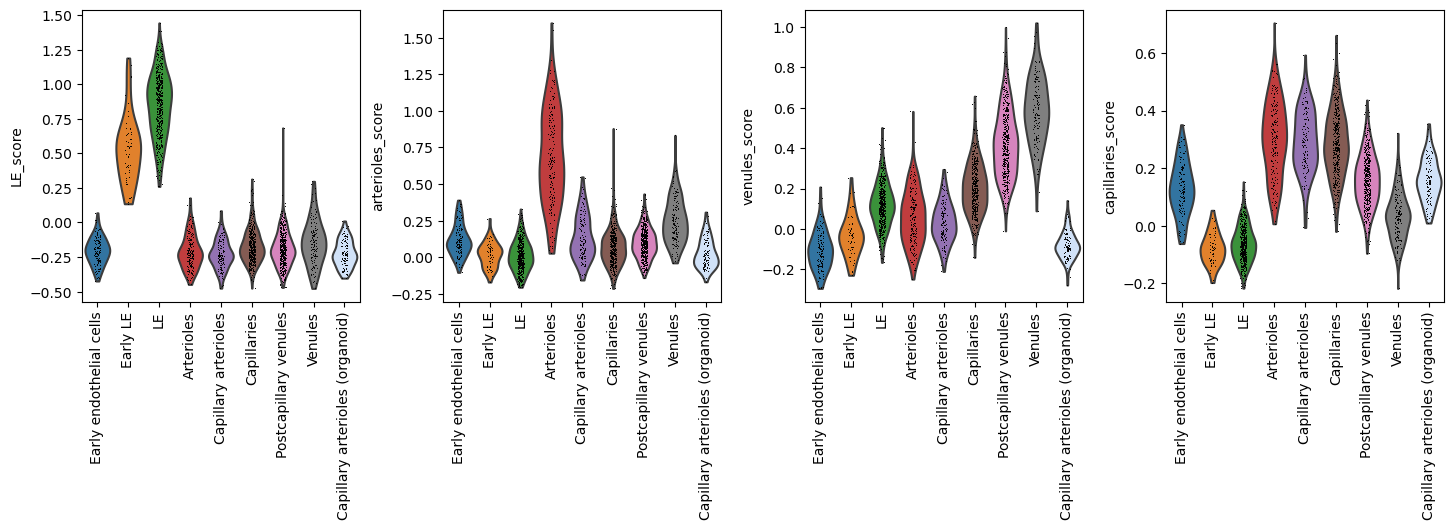

In [30]:
sc.pl.violin(edata, ['LE_score', 'arterioles_score', 'venules_score', 'capillaries_score'], groupby='joint_annot_copy', rotation=90, size=0.7)
#sc.pl.violin(edata, ['LE_score', 'arterioles_score', 'venules_score', 'capillaries_score'], groupby='joint_annot_copy', rotation=90, size=0.7, save='celltype_scores.pdf')